In [1]:
import os
import numpy as np


def find_best(checkpoint, task):
    log_files_a = os.listdir(checkpoint+"/")
    log_files_b = []

    for file in log_files_a:
        file_split = file.split(".")
        if(file_split[-1]=="txt"):
            file_split_2 = file_split[0].split("_")
            if(file_split_2[0]=="session" and file_split_2[1]==str(task) ):
                f = np.loadtxt(checkpoint+"/"+file, skiprows=1)
                best_acc = max(f[-1,-1], f[-1,-2])
                if(file_split_2[-1]!="RT"):
                    return best_acc
                    
    return best_acc


In [2]:
import numpy as np
from collections import Counter
import pickle


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x)**(1/2) 
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def get_correct(acc_task, task, chunks, start_point, class_per_task):
        correct = 0
        correct2 = 0
        task_scores = []
        class_scores = []
        targets = []
        targets_pred = []
        for t in range(task+1):
            list_0 = []
            list_1 = []
            list_2 = []
            list_3 = []
            for i in range(chunks):
                acc_task_0 = acc_task[start_point + i]
                list_0.append(acc_task_0[t][0].detach().cpu().numpy())
                list_1.append(acc_task_0[t][1].detach().cpu().numpy())
                list_2.append(acc_task_0[t][2])
                list_3.append(acc_task_0[t][3].detach().cpu().numpy())
            list_0 = np.array(list_0)
            list_1 = np.array(list_1)
            list_2 = np.array(list_2)
            list_3 = np.array(list_3)
            
            targets_pred.append(list_0)
            class_scores.append(list_1)
            task_scores.append(list_2)
            targets.append(list_3)
            
        m = task_scores[0]
        task_scores2 = []
        for t2 in range(task+1):
            m2 = m[:,t2:(t2+1)]
            m3 = np.max(m2, 1)
            task_scores2.append(np.mean(m3))
        pred_task = np.argmax(task_scores2)  
        if(pred_task == targets[0][0]//class_per_task):
            correct2 += chunks
            for j in range(chunks):
                local_t = np.argmax(class_scores[pred_task][j])
                pred_x = [targets_pred[pred_task][j][local_t]]
                target_x = targets[0][j]
                if(target_x in pred_x+pred_task*class_per_task):
                    correct += 1 
        return correct, correct2
    
def get_mata_score(p, task, chunks):
    task_samples = {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500, 10: 500, 11: 500, 12: 500, 13: 500, 14: 500, 15: 500, 16: 500, 17: 500, 18: 500, 19: 500}
    total_samples = np.sum([task_samples[x] for x in range(task+1)])
    class_per_task = 5
    with open(p + "/meta_task_test_list_"+str(task)+".pickle", 'rb') as handle:
        acc_task = pickle.load(handle)
    correct = 0
    correct2= 0
    for tt in range(task+1):
        ctask_samples = np.sum([task_samples[x] for x in range(tt)])
        for class_id in range(task_samples[tt]//chunks):
            start_point = ctask_samples + class_id*chunks
            c, c2 = get_correct(acc_task, task, chunks, start_point, class_per_task)
            correct += c
            correct2 += c2

        new_chunk = task_samples[tt]-(class_id+1)*chunks
        if(new_chunk>0):
            start_point = ((task_samples[tt]//chunks)*chunks)
            c, c2 = get_correct(acc_task, t, new_chunk, start_point, class_per_task)
            correct += c
            correct2 += c2
    return correct/total_samples*100, correct2/total_samples*100

# print(get_mata_score("models/cifar100/meta2_cifar_T20_8", 1, 20) )           


# (79.5, 97.33333333333334)


In [4]:
models_dic = [
    ["results/cifar100/meta2_cifar_T20_8",       "brown",          "1.25M, ex=2000a, 70ep, RAdam, iReptile, bs=256, r=1",       "<-"   ],  
    ["results/cifar100/meta2_cifar_T20_9",       "brown",          "1.25M, ex=2000a, 70ep, RAdam, iReptile, bs=256, r=1",       "<-"   ],  
    ["results/cifar100/meta2_cifar_T20_10",       "g",          "1.25M, ex=2000a, 70ep, RAdam, iReptile, bs=256, r=1",       "<-"   ],  
    ["results/cifar100/meta2_cifar_T20_11",       "r",          "b = 0.2",       "<-"   ],  
    ["results/cifar100/meta2_cifar_T20_12",       "blue",          "auto = 0.05",       "<-"   ],  
    ["results/cifar100/meta2_cifar_T20_13",       "black",          "auto = 2",       "<-"   ],  
    ["results/cifar100/meta2_cifar_T20_14",       "black",          "auto = 3",       "<-"   ],  

]

91.4,91.8,92.3333,91.45,91.16,90.0,90.2286,88.05,86.9556,85.44,85.6545,84.0333,79.0923,77.2571,72.68,70.0,69.9059,70.0556,71.8421,70.53
88.8,87.0,90.7333,90.75,91.16,90.1333,89.3143,89.85,87.5556,87.04,87.8727,87.2833,84.2308,81.8714,74.3733,73.9,72.2471,71.9667,67.4737,63.98
90.0,91.6,92.0667,91.1,91.92,90.7667,90.6286,88.275,86.5556,86.78,86.9636,84.9,83.2615,78.9571,77.52,79.0375,73.9765,73.1778,76.2947,73.94
86.4,74.8,87.1333,88.35,90.4,89.1667,88.8,88.925,87.4667,88.28,87.5818,87.1833,86.2,84.8857,82.36,81.4625,80.6353,82.5,82.8105,79.53
89.8,91.2,92.7333,90.8,91.12,90.6333,89.5143,87.7,85.2667,88.0,85.6545,85.7,82.1231,81.8143,76.6933,74.475,74.5412,70.8444,74.7368,70.47
88.8,91.3,91.9333,91.4,91.72,90.1333,89.4286,87.575,85.8889,87.54,87.4,87.1833,83.6154,79.9429,78.7733,77.8,76.9412,80.9444,79.8105,74.73
89.8,90.6,91.0667,91.15,91.16,90.5,89.8571,88.375,87.1778,88.3,86.6,87.1,82.8923,80.4714,80.7867,78.775,80.0941,78.5778,79.6105,77.15


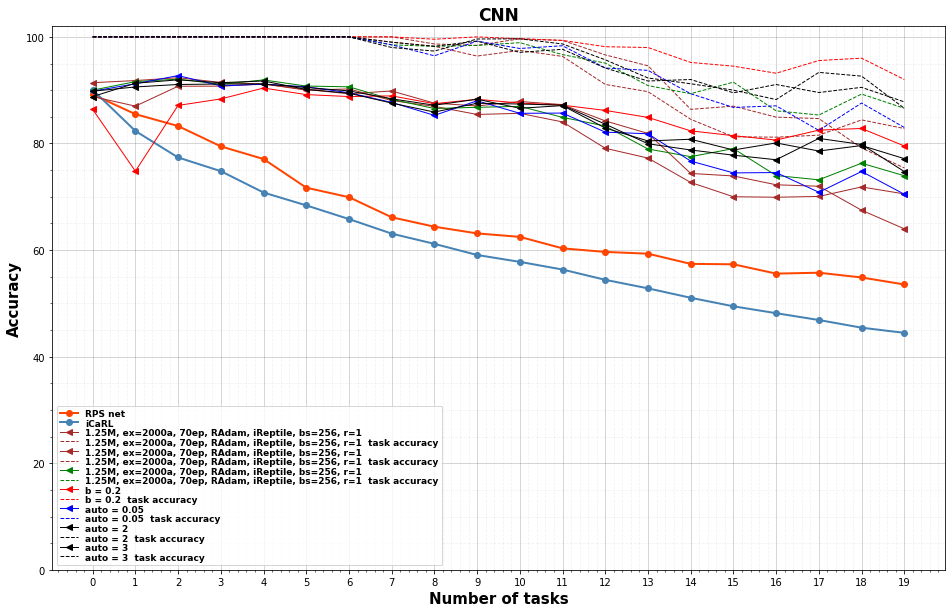

In [5]:
import matplotlib.pyplot as plt 
import numpy as np
import pickle
x = range(20)

icarl = [90.05,82.34,77.37,74.80,70.79,68.38,65.81,63.08,61.16,59.07,57.78,56.34,54.41,52.81,51.04,49.44,48.15,46.87,45.43,44.46]
ours = [89.2,85.5,83.266666,79.45,77.08,71.7,69.914286,66.15,64.377778,63.12,62.472727,60.316667,59.646154,59.314286,57.4,57.325,55.576471,55.744444,54.852632,53.54]



plt.figure(figsize=(16,10))

chunks = 20

plt.plot(x, ours,  "o-", linewidth=2, c="orangered", label="RPS net")
plt.plot(x, icarl, "o-", linewidth=2, c="steelblue", label="iCaRL")

for i,p in enumerate(models_dic):
    z = np.zeros_like(list(x))*0.0
    z2 = np.zeros_like(list(x))*0.0
    ps = "models/" + "/".join(p[0].split("/")[1:])
    try:
        z = np.load(p[0]+"/meta_"+str(chunks)+".npy")
        z2 = np.load(p[0]+"/meta_task_"+str(chunks)+".npy")
        if(np.sum(z>0)<20):
            for j in range(np.sum(z>0), len(icarl)):
                try:
                    z[j], z2[j] = get_mata_score(ps , j, chunks)
                except Exception as e:
                    pass
            np.save(p[0]+"/meta_"+str(chunks)+".npy", z)
            np.save(p[0]+"/meta_task_"+str(chunks)+".npy", z2)
    except:
        for j in range(20):
            try:
                z[j], z2[j] = get_mata_score(ps , j, chunks)
            except Exception as e:
                pass
        np.save(p[0]+"/meta_"+str(chunks)+".npy", z)
        np.save(p[0]+"/meta_task_"+str(chunks)+".npy", z2)
        
    plt.plot(x, z, p[3], linewidth=1, c = p[1], label=p[2])
    plt.plot(x, z2, "--", linewidth=1, c = p[1], label=p[2] + "  task accuracy")
    
    print(",".join([str(np.around(i,4)) for i in z]) )

plt.grid(b=True, which='major', color='gray', linestyle='-', alpha=0.4)
plt.grid(b=True, which='minor', color='gray', linestyle='--', alpha=0.1)
plt.minorticks_on()

plt.ylim([0,102])
plt.legend(loc='lower left',  ncol=1, handleheight=1.0, labelspacing=0.05, prop={'size': 9, "weight":"bold"})

plt.xlabel("Number of tasks", fontweight='bold', fontsize=15)
plt.ylabel("Accuracy", fontweight='bold', fontsize=15)
plt.title("CNN", fontweight='bold', fontsize=17) 
plt.xticks(range(20))
# plt.savefig("plot_data/meta_20.pdf")
plt.show()



In [124]:
np.exp(-3*20/20)

0.049787068367863944

0.004
0.002
0.013999999999999999
0.042
0.01
0.006000000000000001
0.002


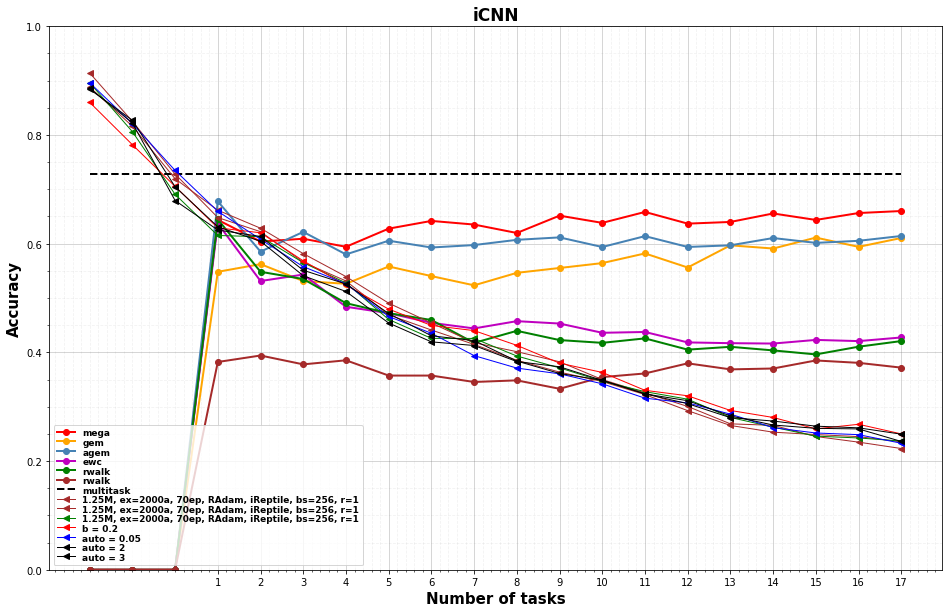

In [190]:
import matplotlib.pyplot as plt 
import numpy as np
import pickle
x = range(-2,18)

mega = [0,0,0,0.6437,0.6038,0.609,0.5942,0.6276,0.6418,0.6351,0.6196,0.6515,0.6382,0.6583,0.6368,0.6399,0.6555,0.6436,0.6563,0.66]
gem = [0,0,0,0.5482,0.5623,0.5312,0.5261,0.558,0.5403,0.5233,0.5463,0.5552,0.5642,0.582,0.5561,0.5969,0.591,0.6111,0.5941,0.6104]
agem =  [0,0,0,0.6778,0.5853,0.6216,0.5802,0.6054,0.5929,0.5974,0.607,0.6115,0.5938,0.6138,0.5939,0.5969,0.6103,0.6014,0.6052,0.6141]
ewc = [0,0,0,0.6371,0.5312,0.5431,0.4839,0.4721,0.4543,0.444,0.4574,0.453,0.436,0.4375,0.4183,0.4169,0.4162,0.4229,0.4207,0.4274]
rwalk = [0,0,0,0.6445,0.5482,0.5349,0.4905,0.4721,0.4595,0.4174,0.4396,0.4226,0.4175,0.4257,0.405,0.4102,0.4036,0.3962,0.4104,0.4208]
mer = [0,0,0,0.3823,0.3942,0.3779,0.3854,0.3573,0.3573,0.3455,0.3485,0.333,0.3545,0.3612,0.3798,0.3687,0.3703,0.3851,0.3807,0.3719]
# multitask = [0.6847]*20
multitask = [0.728]*20


plt.figure(figsize=(16,10))

# plt.plot(x, ours,  "o-", linewidth=2, c="orangered", label="ours")
plt.plot(x, mega, "o-", linewidth=2, c="red", label="mega")
plt.plot(x, gem, "o-", linewidth=2, c="orange", label="gem")
plt.plot(x, agem, "o-", linewidth=2, c="steelblue", label="agem")
plt.plot(x, ewc, "o-", linewidth=2, c="m", label="ewc")
plt.plot(x, rwalk, "o-", linewidth=2, c="green", label="rwalk")
plt.plot(x, mer, "o-", linewidth=2, c="brown", label="rwalk")
plt.plot(x, multitask, "--", linewidth=2, c="black", label="multitask")

for i,p in enumerate(models_dic):
    z = np.zeros((20,))*0.0
    ps = "models/" + "/".join(p[0].split("/")[1:])
    for j in range(0,20):
        try:
            with open(ps + "/acc_task_test_"+str(j)+".pickle", 'rb') as handle:
                acc_task = pickle.load(handle)
            if(j==19):
                print((min(acc_task.values()))/100)
#                 print([np.around(x/100,4) for x in acc_task.values()])
#             print(acc_task)
            z[j] = np.sum([acc_task[x] for x in range(j+1)])/(j+1)/100.0
#             z[j] = acc_task[j]
        except Exception as e:
#             print(e)
            pass
#     print(",".join([str(i) for i in z]) )
    plt.plot(x, z, p[3], linewidth=1, c = p[1], label=p[2])
    
plt.grid(b=True, which='major', color='gray', linestyle='-', alpha=0.4)
plt.grid(b=True, which='minor', color='gray', linestyle='--', alpha=0.1)
plt.minorticks_on()

plt.ylim([0,1])
# plt.xlim([0.97,17.2])
plt.legend(loc='lower left',  ncol=1, handleheight=1.0, labelspacing=0.05, prop={'size': 9, "weight":"bold"})

plt.xlabel("Number of tasks", fontweight='bold', fontsize=15)
plt.ylabel("Accuracy", fontweight='bold', fontsize=15)
plt.title("iCNN", fontweight='bold', fontsize=17) 
plt.xticks(range(1,18))
# plt.savefig("reptile.pdf")
plt.show()

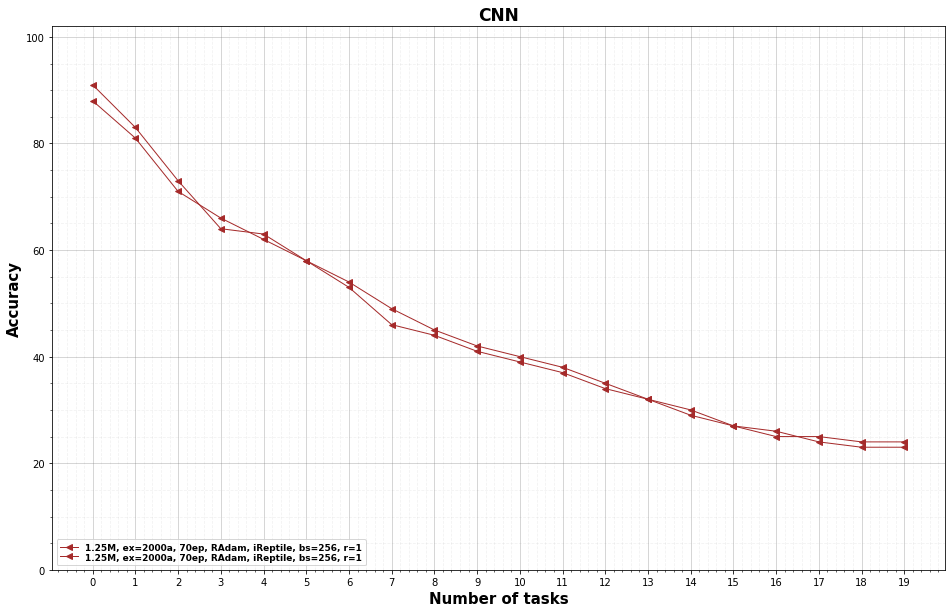

In [36]:
import matplotlib.pyplot as plt 
import numpy as np
x = range(20)
# icarl = [88.5, 78.39, 72.34, 66.94, 63.50, 60.23, 56.63, 54.17, 51.23, 49.10]
# ours = [88.8, 81.3, 77.266667, 72.575, 67.98, 66.0, 64.328571, 62.1, 59.744444, 57.36]

# models_dic = [
#     ["results/cifar100/meta_twohead_T20_1",       "brown",          "base 17M, meta 17M, ex=2000, gamma=3",       "o-"   ], #todo
#     ["results/cifar100/meta_twohead_T20_2",       "g",          "base 17M, meta 17M, ex=2000, gamma=3, b=0.2",       "o-"   ], #todo
#     ["results/cifar100/meta_twohead_T20_3",       "gold",          "base 11M, meta 17M, ex=2000, gamma=3, b=0.2",       "<-"   ], #todo
#     ["results/cifar100/meta_twohead_T20_4",       "orange",          "base 11M, meta 17M, ex=2000, gamma=1, b=auto",       "<-"   ], #todo
# #     ["results/cifar100/meta_twohead_T20_5",       "black",          "base 11M, meta 17M, ex=2000, gamma=1, b=auto",       "<-"   ], #todo
    
# ]

plt.figure(figsize=(16,10))

# plt.plot(x, ours,  "o-", linewidth=2, c="orangered", label="ours")
# plt.plot(x, icarl, "o-", linewidth=2, c="steelblue", label="iCaRL")

for i,p in enumerate(models_dic):
    z = np.zeros_like(list(x))
    for j in range(len(list(x))):
        
        try:
            z[j] = find_best(p[0], j)

        except Exception as e:
#             print(e)
            pass
    plt.plot(x, z, p[3], linewidth=1, c = p[1], label=p[2])
    
plt.grid(b=True, which='major', color='gray', linestyle='-', alpha=0.4)
plt.grid(b=True, which='minor', color='gray', linestyle='--', alpha=0.1)
plt.minorticks_on()

plt.ylim([0,102])
plt.legend(loc='lower left',  ncol=1, handleheight=1.0, labelspacing=0.05, prop={'size': 9, "weight":"bold"})

plt.xlabel("Number of tasks", fontweight='bold', fontsize=15)
plt.ylabel("Accuracy", fontweight='bold', fontsize=15)
plt.title("CNN", fontweight='bold', fontsize=17) 
plt.xticks(range(20))
# plt.savefig("reptile.pdf")
plt.show()

In [42]:
import scipy

def comb(a,b):
    aa = scipy.math.factorial(a)
    bb = scipy.math.factorial(b)
    ab = scipy.math.factorial(a-b)
    return aa/bb/ab

def binomial_prob(n,r,p):
    
    return comb(n,r)* (p**(r))* ((1-p)**(n-r))


def get_correct(acc_task, task, chunks, start_point, class_per_task):
    correct = 0
    correct2 = 0
    task_scores = []
    class_scores = []
    targets = []
    targets_pred = []
    for t in range(task+1):
        list_0 = []
        list_1 = []
        list_2 = []
        list_3 = []
        for i in range(chunks):
            acc_task_0 = acc_task[start_point + i]
            list_0.append(acc_task_0[t][0].detach().cpu().numpy())
            list_1.append(acc_task_0[t][1].detach().cpu().numpy())
            list_2.append(acc_task_0[t][2])
            list_3.append(acc_task_0[t][3].detach().cpu().numpy())
        list_0 = np.array(list_0)
        list_1 = np.array(list_1)
        list_2 = np.array(list_2)
        list_3 = np.array(list_3)

        targets_pred.append(list_0)
        class_scores.append(list_1)
        task_scores.append(list_2)
        targets.append(list_3)

    m = task_scores[0]
    task_scores2 = []
    for t2 in range(task+1):
        m2 = m[:,t2:(t2+1)]
        m3 = np.max(m2, 1)
        task_scores2.append(np.mean(m3))
    pred_task = np.argmax(task_scores2)  
    if(pred_task == targets[0][0]//class_per_task):
        correct2 += chunks
        for j in range(chunks):
            local_t = np.argmax(class_scores[pred_task][j])
            pred_x = [targets_pred[pred_task][j][local_t]]
            target_x = targets[0][j]
            if(target_x in pred_x+pred_task*class_per_task):
                correct += 1 
    return correct, correct2
                            
num_task = 20
total_num_class = 100
class_per_task = total_num_class//num_task

for t in [19]:
    task = t
    ps = "results/cifar100/meta2_cifar_T20_12"
    
    task_samples = {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500, 10: 500, 11: 500, 12: 500, 13: 500, 14: 500, 15: 500, 16: 500, 17: 500, 18: 500, 19: 500}
    total_samples = np.sum([task_samples[x] for x in range(t+1)])

    with open("models/" + "/".join(ps.split("/")[1:]) + "/meta_task_test_list_"+str(t)+".pickle", 'rb') as handle:
        acc_task = pickle.load(handle)
    
    with open("models/" + "/".join(ps.split("/")[1:]) + "/acc_task_test_"+str(t)+".pickle", 'rb') as handle:
        acc_test = pickle.load(handle)
    
    range_acc = (max(acc_test.values())-min(acc_test.values()))/100
    p0 = np.min(list(acc_test.values()))/100
#     p0 = (p0 - range_acc/2)

    p0_hat = p0 + (1-p0)/((class_per_task*(t+1))-1)*(class_per_task-1)
    print(p0, p0_hat)
    found = 0
    for chunk in range(2,200):
        p = 0
        
        for j in range(max(2*(int(chunk/(task+1))),2),chunk):
            p += binomial_prob(chunk,j, p0_hat)
            if(p>=0.95):
                found = 1
                break
        if(found == 1):       
            break
    
    for chunks in [chunk]:
        correct = 0
        correct2= 0
        for tt in range(task+1):
            ctask_samples = np.sum([task_samples[x] for x in range(tt)])
            for class_id in range(task_samples[tt]//chunks):
                start_point = ctask_samples + class_id*chunks
                c, c2 = get_correct(acc_task, t, chunks, start_point, class_per_task)
                correct += c
                correct2 += c2
            
            new_chunk = task_samples[tt]-(class_id+1)*chunks
            if(new_chunk>0):
                start_point = ((task_samples[tt]//chunks)*chunks)
                c, c2 = get_correct(acc_task, t, new_chunk, start_point, class_per_task)
                correct += c
                correct2 += c2
    
    print("task = ", t, "\t", 
          "chunk = ", chunk, "\t", 
          "predicted accuracy = ", p, "\t", 
          "actual task accuracy = ", correct2/total_samples*100)



0.01 0.05


OverflowError: integer division result too large for a float

In [193]:
range_acc = (max(acc_test.values())-min(acc_test.values()))/100
p0 = np.min(list(acc_test.values()))/100
# p0 = (p0 - range_acc/2)

p0_hat = p0 + (1-p0)/((class_per_task*(t+1))-1)*(class_per_task-1)
print(p0, p0_hat)
found = 0
for chunk in range(2,50):
    p = 0

    for j in range(max(2*(int(chunk/(task+1))),2),chunk):
        p += binomial_prob(chunk,j, p0_hat)
        if(p>=0.95):
            found = 1
            break
    if(found == 1):       
        break

print(chunk)
for chunks in [chunk]:
    correct = 0
    correct2= 0
    for tt in range(task+1):
        ctask_samples = np.sum([task_samples[x] for x in range(tt)])
        for class_id in range(task_samples[tt]//chunks):
            start_point = ctask_samples + class_id*chunks
            c, c2 = get_correct(acc_task, t, chunks, start_point, class_per_task)
            correct += c
            correct2 += c2

        new_chunk = task_samples[tt]-(class_id+1)*chunks
        if(new_chunk>0):
            start_point = ((task_samples[tt]//chunks)*chunks)
            c, c2 = get_correct(acc_task, t, new_chunk, start_point, class_per_task)
            correct += c
            correct2 += c2

print("task = ", t, "\t", 
      "chunk = ", chunk, "\t", 
      "predicted accuracy = ", p, "\t", 
      "actual task accuracy = ", correct2/total_samples*100)



0.042 0.0807070707070707
49


KeyboardInterrupt: 

In [65]:
t = 19
class_per_task = 5
range_acc = (max(list(acc_test.values()))-min(list(acc_test.values())))/100
p0 = np.mean(list(acc_test.values()))/100
# p0 = (p0 - 0.36*range_acc)
p0 = (p0 - range_acc*(1-np.exp(-1)))

p0_hat = p0 + (1-p0)/((class_per_task*(t+1))-1)*(class_per_task-1) 
print(p0, p0_hat, range_acc)

for chunk in range(5,100):
    p = 0
    for j in range(int(np.around(chunk/(task+1))+1),chunk+1):
#     for j in range(3,chunk+1):
        p += binomial_prob(chunk,j, p0_hat)
    
    if(p>=0.95):
        found = 1
        break
print(p, chunk)

-0.060503939296450704 -0.017655295284472905 0.46399999999999997
0.13971191402086847 99


In [28]:
for chunks in [45]:
    correct = 0
    correct2= 0
    for tt in range(task+1):
        ctask_samples = np.sum([task_samples[x] for x in range(tt)])
        for class_id in range(task_samples[tt]//chunks):
            start_point = ctask_samples + class_id*chunks
            c, c2 = get_correct(acc_task, t, chunks, start_point, class_per_task)
            correct += c
            correct2 += c2

        new_chunk = task_samples[tt]-(class_id+1)*chunks
        if(new_chunk>0):
            start_point = ((task_samples[tt]//chunks)*chunks)
            c, c2 = get_correct(acc_task, t, new_chunk, start_point, class_per_task)
            correct += c
            correct2 += c2

print("task = ", t, "\t", 
      "chunk = ", chunks, "\t", 
      "predicted accuracy = ", p, "\t", 
      "actual task accuracy = ", correct2/total_samples*100,
      "actual class accuracy = ", correct/total_samples*100
     )



task =  19 	 chunk =  45 	 predicted accuracy =  0.9520838164455753 	 actual task accuracy =  96.75 actual class accuracy =  83.49


In [108]:
a = np.load("results/cifar100/meta_twohead_1/seed.npy")
print(a)

7572
